# Feedforward Neural Network with PyTorch on [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist)
By [Zahra Taheri](https://github.com/zahta), October 6, 2020

### Import libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import os

In [2]:
#Define path to the directory

path = os.getcwd()

mypath = path+"\Fashion-MNIST"

os.chdir(mypath)

print(os.getcwd())

C:\Users\Zahra\github\Deep_Learning_F20_Assignments\Assignments\Assignment_Set_2\Fashion-MNIST files\Fashion-MNIST


## Loading Fashion-MNIST into NumPy arrays

In [3]:
from mlxtend.data import loadlocal_mnist

#load train_data and train_labels
train_data, train_labels= loadlocal_mnist(
        images_path='train-images-idx3-ubyte', 
        labels_path='train-labels-idx1-ubyte')
 
#load test_data and test_labels
test_data, test_labels= loadlocal_mnist(
        images_path='t10k-images-idx3-ubyte', 
        labels_path='t10k-labels-idx1-ubyte')

In [4]:
print(train_data.shape)   # 28*28=784
print(train_labels.shape)

(60000, 784)
(60000,)


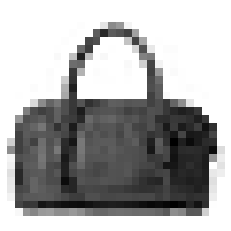

In [5]:
some_digit = train_data[11000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary)
plt.axis("off")
plt.show()

## Preparation of the dataset

In [6]:
# Data standardization
#from sklearn.preprocessing import StandardScaler

#scaler = StandardScaler()
#train_data = scaler.fit_transform(train_data)
#test_data= scaler.transform(test_data)

In [7]:
train_data= train_data.reshape((train_data.shape[0],28,28))
test_data= test_data.reshape((test_data.shape[0],28,28))

In [8]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

tensor_x = torch.Tensor(train_data) # transform to torch tensor
tensor_y = torch.Tensor(train_labels)
tensor_y = tensor_y.type(torch.LongTensor)

train_dataset = TensorDataset(tensor_x,tensor_y) # create your dataset
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True) # create your dataloader

In [9]:
tensor_x2 = torch.Tensor(test_data) # transform to torch tensor
tensor_y2 = torch.Tensor(test_labels)
tensor_y2 = tensor_y2.type(torch.LongTensor)

test_dataset = TensorDataset(tensor_x2,tensor_y2) # create your test dataset
test_loader = DataLoader(test_dataset, batch_size=100,  shuffle=False) # create your dataloader

In [10]:
tensor_y

tensor([9, 0, 0,  ..., 3, 0, 5])

## Building Feedforward Neural Networks with PyTorch

### Model A: 1 hidden layer (ReLU activation)

#### Steps
- Step 1: Load dataset
- Step 2: Make dataset iterable
- Step 3: Create model class
- Step 4: Instantiate model class
- Step 5: Instantiate loss class
- Step 6: Instantiate optimizer class
- Step 7: Train the model


In [11]:
# import libraries
import torch
import torch.nn as nn

from torch.autograd import Variable
from torchsummary import summary

In [12]:
batch_size = 100
n_iters = 3000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
num_epochs

5

#### Create model class

In [13]:
class FeedforwardNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FeedforwardNeuralNetworkModel, self).__init__()
        # linear function
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # non-linearity
        self.relu = nn.ReLU()
        # linear function
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # linear function
        out = self.fc1(x)
        # non-linearity
        out = self.relu(out)
        #linear function
        out = self.fc2(out)
        return out       
    

In [14]:
#  Instantiate model class
input_dim = 28*28
output_dim = 10
hidden_dim = 100 

model = FeedforwardNeuralNetworkModel(input_dim, hidden_dim, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()
    

In [15]:
summary(model, (1,28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]          78,500
              ReLU-2               [-1, 1, 100]               0
            Linear-3                [-1, 1, 10]           1,010
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.30
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


In [16]:
#  Instantiate loss class
criterion=nn.CrossEntropyLoss()

#  Instantiate optimizer class
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [17]:
# Train the model

train_loss = []
train_accuracy = []

iter = 0
for epoch in range(num_epochs):
    
    '''
    One iteration
    '''
    # Calculate Accuracy         
    correct_1 = 0
    total_1 = 0
    for i, (images, labels) in enumerate(train_loader):
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            images = Variable(images.view(-1, 28*28).cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images.view(-1, 28*28))
            labels = Variable(labels)
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        '''
        Save accuracy to draw accuracy curve
        '''
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
                
        # Total number of labels
        total_1 += labels.size(0)
           
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        # Total correct predictions
        if torch.cuda.is_available():
                    correct_1 += (predicted.cpu() == labels.cpu()).sum() # because .sum() function does not work on GPU
        else:                
                    correct_1 += (predicted == labels).sum()
            
        accuracy = 100 * correct_1 // total_1
        train_accuracy.append(accuracy)
        ''''''
        
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        
        '''
        Save loss to draw accuracy curve
        '''
        train_loss.append(loss)
        ''''''
        
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        ''''''
        
        iter += 1
    
        # Testing the model
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    images = Variable(images.view(-1, 28*28).cuda())
                else:
                    images = Variable(images.view(-1, 28*28))    
                    
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
           
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() # because .sum() function does not work on GPU
                else:                
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * correct // total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.data, accuracy))
            

Iteration: 500. Loss: 0.6571899652481079. Accuracy: 73
Iteration: 1000. Loss: 0.7530586123466492. Accuracy: 79
Iteration: 1500. Loss: 0.4286539554595947. Accuracy: 81
Iteration: 2000. Loss: 0.44833213090896606. Accuracy: 81
Iteration: 2500. Loss: 0.506173849105835. Accuracy: 81
Iteration: 3000. Loss: 0.5495560169219971. Accuracy: 83


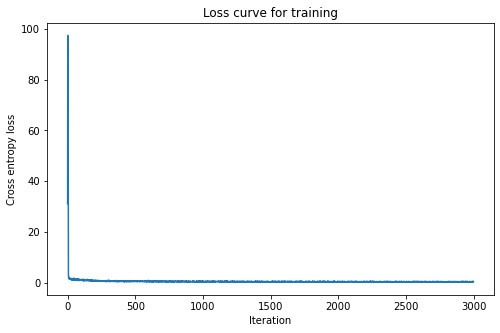

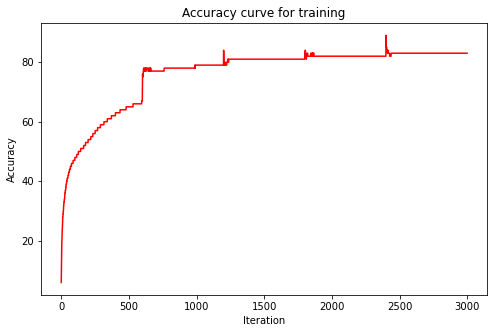

In [18]:
#Plots the loss and accuracy curves

plt.figure(figsize=(8,5))
plt.plot(range(len(train_loss)), train_loss)
plt.xlabel("Iteration")
plt.ylabel("Cross entropy loss")
plt.title("Loss curve for training")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(len(train_accuracy)), train_accuracy, c='r')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy curve for training")
plt.show()

### Model B: 1 Hidden Layer Feedforward Neural Network (Tanh Activation)
Just create model class is different from Model A.

In [19]:
batch_size = 100
n_iters = 3000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
num_epochs

5

#### Create model class

In [20]:
class FeedforwardNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FeedforwardNeuralNetworkModel, self).__init__()
        # linear function
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # non-linearity
        self.tanh = nn.Tanh()
        # linear function
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # linear function
        out = self.fc1(x)
        # non-linearity
        out = self.tanh(out)
        #linear function
        out = self.fc2(out)
        return out       
    

In [21]:
#  Instantiate model class
input_dim = 28*28
output_dim = 10
hidden_dim = 100 

model = FeedforwardNeuralNetworkModel(input_dim, hidden_dim, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()
    

In [22]:
summary(model, (1,28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]          78,500
              Tanh-2               [-1, 1, 100]               0
            Linear-3                [-1, 1, 10]           1,010
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.30
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


In [23]:
#  Instantiate loss class
criterion=nn.CrossEntropyLoss()

#  Instantiate optimizer class
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [24]:
# Train the model

train_loss = []
train_accuracy = []

iter = 0
for epoch in range(num_epochs):
    
    '''
    One iteration
    '''
    # Calculate Accuracy         
    correct_1 = 0
    total_1 = 0
    for i, (images, labels) in enumerate(train_loader):
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            images = Variable(images.view(-1, 28*28).cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images.view(-1, 28*28))
            labels = Variable(labels)
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        '''
        Save accuracy to draw accuracy curve
        '''
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
                
        # Total number of labels
        total_1 += labels.size(0)
           
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        # Total correct predictions
        if torch.cuda.is_available():
                    correct_1 += (predicted.cpu() == labels.cpu()).sum() # because .sum() function does not work on GPU
        else:                
                    correct_1 += (predicted == labels).sum()
            
        accuracy = 100 * correct_1 // total_1
        train_accuracy.append(accuracy)
        ''''''
        
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        
        '''
        Save loss to draw accuracy curve
        '''
        train_loss.append(loss)
        ''''''
        
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        ''''''
        
        iter += 1
    
        # Testing the model
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    images = Variable(images.view(-1, 28*28).cuda())
                else:
                    images = Variable(images.view(-1, 28*28))    
                    
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
           
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() # because .sum() function does not work on GPU
                else:                
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * correct // total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.data, accuracy))
            

Iteration: 500. Loss: 0.8784054517745972. Accuracy: 71
Iteration: 1000. Loss: 0.826201319694519. Accuracy: 75
Iteration: 1500. Loss: 0.7593299746513367. Accuracy: 76
Iteration: 2000. Loss: 0.6753838062286377. Accuracy: 78
Iteration: 2500. Loss: 0.5091896057128906. Accuracy: 79
Iteration: 3000. Loss: 0.5716516971588135. Accuracy: 79


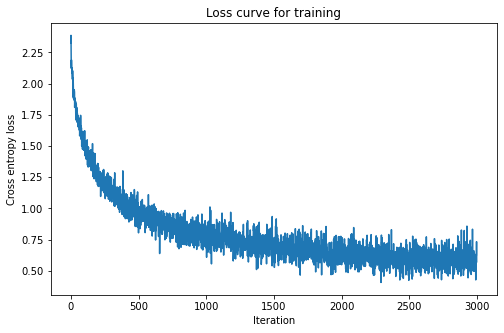

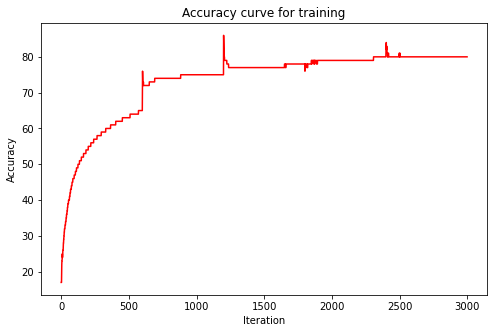

In [25]:
#Plots the loss and accuracy curves

plt.figure(figsize=(8,5))
plt.plot(range(len(train_loss)), train_loss)
plt.xlabel("Iteration")
plt.ylabel("Cross entropy loss")
plt.title("Loss curve for training")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(len(train_accuracy)), train_accuracy, c='r')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy curve for training")
plt.show()

### Model C: 2 Hidden Layers Feedforward Neural Network (ReLU Activation)

### Create model class

In [26]:
class FeedforwardNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FeedforwardNeuralNetworkModel, self).__init__()
        # linear function 1: 
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # non-linearity 1
        self.relu1 = nn.ReLU()
        
        # linear function 2:
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # non-linearity 2
        self.relu2 = nn.ReLU()
        
        # linear function (readout)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # linear function 1
        out = self.fc1(x)
        # non-linearity 1
        out = self.relu1(out)
        
        # linear function 2
        out = self.fc2(out)
        # non-linearity 2
        out = self.relu2(out)
        
        #linear function 3 (readout)
        out = self.fc3(out)
        return out       
    

In [27]:
#  Instantiate model class
input_dim = 28*28
output_dim = 10
hidden_dim = 100 

model = FeedforwardNeuralNetworkModel(input_dim, hidden_dim, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()
    

In [28]:
summary(model, (1,28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]          78,500
              ReLU-2               [-1, 1, 100]               0
            Linear-3               [-1, 1, 100]          10,100
              ReLU-4               [-1, 1, 100]               0
            Linear-5                [-1, 1, 10]           1,010
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.34
Estimated Total Size (MB): 0.35
----------------------------------------------------------------


In [29]:
#  Instantiate loss class
criterion=nn.CrossEntropyLoss()

#  Instantiate optimizer class
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [30]:
# Train the model

train_loss = []
train_accuracy = []

iter = 0
for epoch in range(num_epochs):
    
    '''
    One iteration
    '''
    # Calculate Accuracy         
    correct_1 = 0
    total_1 = 0
    for i, (images, labels) in enumerate(train_loader):
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            images = Variable(images.view(-1, 28*28).cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images.view(-1, 28*28))
            labels = Variable(labels)
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        '''
        Save accuracy to draw accuracy curve
        '''
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
                
        # Total number of labels
        total_1 += labels.size(0)
           
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        # Total correct predictions
        if torch.cuda.is_available():
                    correct_1 += (predicted.cpu() == labels.cpu()).sum() # because .sum() function does not work on GPU
        else:                
                    correct_1 += (predicted == labels).sum()
            
        accuracy = 100 * correct_1 // total_1
        train_accuracy.append(accuracy)
        ''''''
        
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        
        '''
        Save loss to draw accuracy curve
        '''
        train_loss.append(loss)
        ''''''
        
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        ''''''
        
        iter += 1
    
        # Testing the model
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    images = Variable(images.view(-1, 28*28).cuda())
                else:
                    images = Variable(images.view(-1, 28*28))    
                    
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
           
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() # because .sum() function does not work on GPU
                else:                
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * correct // total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.data, accuracy))
            

Iteration: 500. Loss: 0.6204278469085693. Accuracy: 78
Iteration: 1000. Loss: 0.4554538428783417. Accuracy: 81
Iteration: 1500. Loss: 0.44468700885772705. Accuracy: 81
Iteration: 2000. Loss: 0.373912513256073. Accuracy: 83
Iteration: 2500. Loss: 0.28977420926094055. Accuracy: 83
Iteration: 3000. Loss: 0.460571825504303. Accuracy: 84


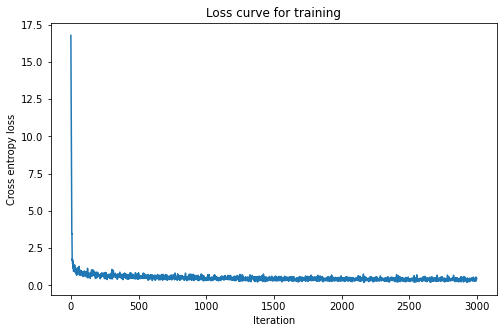

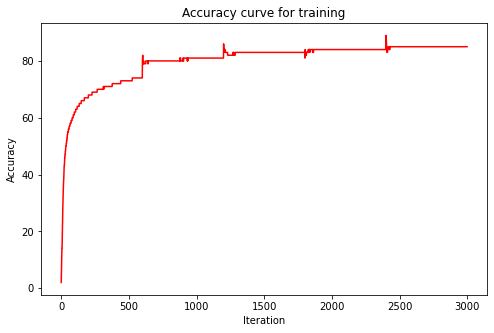

In [31]:
#Plots the loss and accuracy curves

plt.figure(figsize=(8,5))
plt.plot(range(len(train_loss)), train_loss)
plt.xlabel("Iteration")
plt.ylabel("Cross entropy loss")
plt.title("Loss curve for training")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(len(train_accuracy)), train_accuracy, c='r')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy curve for training")
plt.show()

### Model D: 3 Hidden Layers Feedforward Neural Network (ReLU Activation)

#### Create model class

In [32]:
class FeedforwardNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FeedforwardNeuralNetworkModel, self).__init__()
        # linear function 1: 
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # non-linearity 1
        self.relu1 = nn.ReLU()
        
        # linear function 2: 
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # non-linearity 2
        self.relu2 = nn.ReLU()
        
        # linear function 3: 
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        # non-linearity 3
        self.relu3 = nn.ReLU()
        
        # linear function 4 (readout)
        self.fc4 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # linear function 1
        out = self.fc1(x)
        # non-linearity 1
        out = self.relu1(out)
        
        # linear function 2
        out = self.fc2(out)
        # non-linearity 2
        out = self.relu2(out)
        
        # linear function 3
        out = self.fc3(out)
        # non-linearity 3
        out = self.relu3(out)
        
        #linear function 4 (readout)
        out = self.fc4(out)
        return out       
    

In [33]:
#  Instantiate model class
input_dim = 28*28
output_dim = 10
hidden_dim = 100 

model = FeedforwardNeuralNetworkModel(input_dim, hidden_dim, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()
    

In [34]:
summary(model, (1,28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]          78,500
              ReLU-2               [-1, 1, 100]               0
            Linear-3               [-1, 1, 100]          10,100
              ReLU-4               [-1, 1, 100]               0
            Linear-5               [-1, 1, 100]          10,100
              ReLU-6               [-1, 1, 100]               0
            Linear-7                [-1, 1, 10]           1,010
Total params: 99,710
Trainable params: 99,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.38
Estimated Total Size (MB): 0.39
----------------------------------------------------------------


In [35]:
#  Instantiate loss class
criterion=nn.CrossEntropyLoss()

#  Instantiate optimizer class
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [36]:
# Train the model

train_loss = []
train_accuracy = []

iter = 0
for epoch in range(num_epochs):
    
    '''
    One iteration
    '''
    # Calculate Accuracy         
    correct_1 = 0
    total_1 = 0
    for i, (images, labels) in enumerate(train_loader):
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            images = Variable(images.view(-1, 28*28).cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images.view(-1, 28*28))
            labels = Variable(labels)
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        '''
        Save accuracy to draw accuracy curve
        '''
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
                
        # Total number of labels
        total_1 += labels.size(0)
           
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        # Total correct predictions
        if torch.cuda.is_available():
                    correct_1 += (predicted.cpu() == labels.cpu()).sum() # because .sum() function does not work on GPU
        else:                
                    correct_1 += (predicted == labels).sum()
            
        accuracy = 100 * correct_1 // total_1
        train_accuracy.append(accuracy)
        ''''''
        
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        
        '''
        Save loss to draw accuracy curve
        '''
        train_loss.append(loss)
        ''''''
        
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        ''''''
        
        iter += 1
    
        # Testing the model
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    images = Variable(images.view(-1, 28*28).cuda())
                else:
                    images = Variable(images.view(-1, 28*28))    
                    
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
           
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() # because .sum() function does not work on GPU
                else:                
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * correct // total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.data, accuracy))
            

Iteration: 500. Loss: 0.4537968933582306. Accuracy: 80
Iteration: 1000. Loss: 0.3462185561656952. Accuracy: 82
Iteration: 1500. Loss: 0.38188427686691284. Accuracy: 83
Iteration: 2000. Loss: 0.5052550435066223. Accuracy: 84
Iteration: 2500. Loss: 0.3503841459751129. Accuracy: 84
Iteration: 3000. Loss: 0.4283829927444458. Accuracy: 84


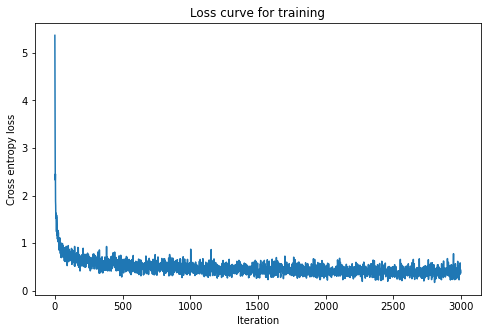

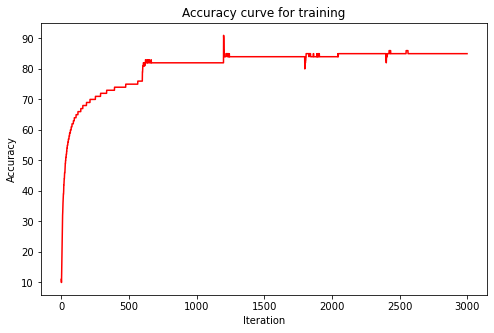

In [37]:
#Plots the loss and accuracy curves

plt.figure(figsize=(8,5))
plt.plot(range(len(train_loss)), train_loss)
plt.xlabel("Iteration")
plt.ylabel("Cross entropy loss")
plt.title("Loss curve for training")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(len(train_accuracy)), train_accuracy, c='r')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy curve for training")
plt.show()

In [38]:
save_model = True
if save_model is True:
    torch.save(model.state_dict(), path+"\\FNN_pytorch_relu3_fashion-mnist.pkl")# only save parameters

### Model E: 5 Hidden Layers Feedforward Neural Network

In [39]:
input_dim = 28*28
output_dim = 10
hidden_dim1 = 100 
hidden_dim2 = 100 
hidden_dim3 = 200 
hidden_dim4 = 300 
hidden_dim5 = 100 

#### Create model class

In [40]:
class FNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, output_dim):
        
        super(FNNModel, self).__init__()
        
        self.f1 = nn.Linear(input_dim,hidden_dim1)
        self.relu1 = nn.ReLU()
        
        self.f2 = nn.Linear(hidden_dim1,hidden_dim2)
        self.relu2 = nn.ReLU()
        
        self.f3 = nn.Linear(hidden_dim2,hidden_dim3)
        self.sigmoid = nn.Tanh()
        
        self.f4 = nn.Linear(hidden_dim3,hidden_dim4)
        self.relu3 = nn.ReLU()
        
        self.f5 = nn.Linear(hidden_dim4,hidden_dim5)
        self.relu4 = nn.ReLU()
        
        self.f6 = nn.Linear(hidden_dim5,output_dim)
        
    def forward(self, x):
        out = self.f1(x)
        out = self.relu1(out)

        out = self.f2(out)
        out = self.relu2(out)
        
        out = self.f3(out)
        out = self.sigmoid(out)
        
        out = self.f4(out)
        out = self.relu3(out)
        
        out = self.f5(out)
        out = self.relu4(out)
        
        out = self.f6(out)
        
        return out       
    

In [41]:
model = FNNModel(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()

In [42]:
summary(model, (1,28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]          78,500
              ReLU-2               [-1, 1, 100]               0
            Linear-3               [-1, 1, 100]          10,100
              ReLU-4               [-1, 1, 100]               0
            Linear-5               [-1, 1, 200]          20,200
              Tanh-6               [-1, 1, 200]               0
            Linear-7               [-1, 1, 300]          60,300
              ReLU-8               [-1, 1, 300]               0
            Linear-9               [-1, 1, 100]          30,100
             ReLU-10               [-1, 1, 100]               0
           Linear-11                [-1, 1, 10]           1,010
Total params: 200,210
Trainable params: 200,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [43]:
batch_size = 64
n_iters = 9400
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
num_epochs

10

In [44]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.01

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [45]:
# Train the model

train_loss = []
train_accuracy = []

iter = 0
for epoch in range(num_epochs):
    
    '''
    One iteration
    '''
    # Calculate Accuracy         
    correct_1 = 0
    total_1 = 0
    for i, (images, labels) in enumerate(train_loader):
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            images = Variable(images.view(-1, 28*28).cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images.view(-1, 28*28))
            labels = Variable(labels)
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        '''
        Save accuracy to draw accuracy curve
        '''
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
                
        # Total number of labels
        total_1 += labels.size(0)
           
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        # Total correct predictions
        if torch.cuda.is_available():
                    correct_1 += (predicted.cpu() == labels.cpu()).sum() # because .sum() function does not work on GPU
        else:                
                    correct_1 += (predicted == labels).sum()
            
        accuracy = 100 * correct_1 // total_1
        train_accuracy.append(accuracy)
        ''''''
        
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        
        '''
        Save loss to draw accuracy curve
        '''
        train_loss.append(loss)
        ''''''
        
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        ''''''
        
        iter += 1
    
        # Testing the model
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    images = Variable(images.view(-1, 28*28).cuda())
                else:
                    images = Variable(images.view(-1, 28*28))    
                    
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
           
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() # because .sum() function does not work on GPU
                else:                
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * correct // total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.data, accuracy))
            

Iteration: 500. Loss: 0.5365772843360901. Accuracy: 77
Iteration: 1000. Loss: 0.4396742284297943. Accuracy: 81
Iteration: 1500. Loss: 0.5066227316856384. Accuracy: 82
Iteration: 2000. Loss: 0.4180179834365845. Accuracy: 84
Iteration: 2500. Loss: 0.3749265670776367. Accuracy: 83
Iteration: 3000. Loss: 0.4152218997478485. Accuracy: 84
Iteration: 3500. Loss: 0.45451289415359497. Accuracy: 85
Iteration: 4000. Loss: 0.32602858543395996. Accuracy: 85
Iteration: 4500. Loss: 0.42606377601623535. Accuracy: 84
Iteration: 5000. Loss: 0.24764001369476318. Accuracy: 85
Iteration: 5500. Loss: 0.25058433413505554. Accuracy: 85
Iteration: 6000. Loss: 0.3025541603565216. Accuracy: 86


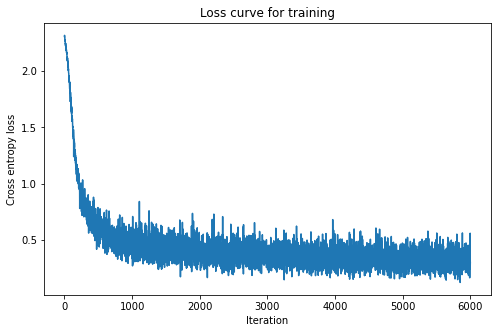

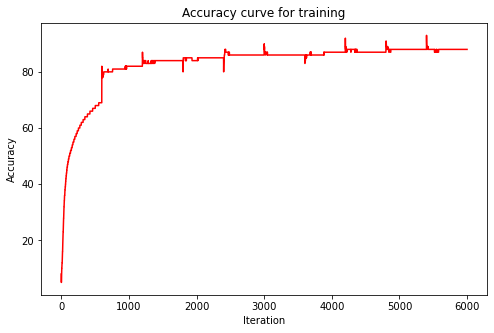

In [46]:
#Plots the loss and accuracy curves

plt.figure(figsize=(8,5))
plt.plot(range(len(train_loss)), train_loss)
plt.xlabel("Iteration")
plt.ylabel("Cross entropy loss")
plt.title("Loss curve for training")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(len(train_accuracy)), train_accuracy, c='r')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy curve for training")
plt.show()

In [47]:
save_model = True
if save_model is True:
    torch.save(model.state_dict(), path+"\\FNN_pytorch_6_layer_fashion-mnist.pkl")# only save parameters

### Model F: 3 Hidden Layers Feedforward Neural Network

In [48]:
input_dim = 28*28
output_dim = 10
hidden_dim1 = 256
hidden_dim2 = 128 

#### Create model class

In [49]:
class FNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        
        super(FNNModel, self).__init__()
        
        self.f1 = nn.Linear(input_dim,hidden_dim1)
        self.relu1 = nn.ReLU()
        
        self.f2 = nn.Linear(hidden_dim1,hidden_dim2)
        self.relu2 = nn.ReLU()
        
        self.f3 = nn.Linear(hidden_dim2,output_dim)
        
    def forward(self, x):
        out = self.f1(x)
        out = self.relu1(out)

        out = self.f2(out)
        out = self.relu2(out)
        
        out = self.f3(out)
        
        return out       
    

In [50]:
model = FNNModel(input_dim, hidden_dim1, hidden_dim2, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()

In [51]:
summary(model, (1,28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]         200,960
              ReLU-2               [-1, 1, 256]               0
            Linear-3               [-1, 1, 128]          32,896
              ReLU-4               [-1, 1, 128]               0
            Linear-5                [-1, 1, 10]           1,290
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.90
Estimated Total Size (MB): 0.91
----------------------------------------------------------------


In [52]:
batch_size = 128
n_iters = 9400
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
num_epochs

20

In [53]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.001

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [54]:
# Train the model

train_loss = []
train_accuracy = []

iter = 0
for epoch in range(num_epochs):
    
    '''
    One iteration
    '''
    # Calculate Accuracy         
    correct_1 = 0
    total_1 = 0
    for i, (images, labels) in enumerate(train_loader):
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            images = Variable(images.view(-1, 28*28).cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images.view(-1, 28*28))
            labels = Variable(labels)
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        '''
        Save accuracy to draw accuracy curve
        '''
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
                
        # Total number of labels
        total_1 += labels.size(0)
           
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        # Total correct predictions
        if torch.cuda.is_available():
                    correct_1 += (predicted.cpu() == labels.cpu()).sum() # because .sum() function does not work on GPU
        else:                
                    correct_1 += (predicted == labels).sum()
            
        accuracy = 100 * correct_1 // total_1
        train_accuracy.append(accuracy)
        ''''''
        
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        
        '''
        Save loss to draw accuracy curve
        '''
        train_loss.append(loss)
        ''''''
        
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        ''''''
        
        iter += 1
    
        # Testing the model
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    images = Variable(images.view(-1, 28*28).cuda())
                else:
                    images = Variable(images.view(-1, 28*28))    
                    
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
           
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() # because .sum() function does not work on GPU
                else:                
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * correct // total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.data, accuracy))
            

Iteration: 500. Loss: 0.5645390748977661. Accuracy: 79
Iteration: 1000. Loss: 0.4668310284614563. Accuracy: 82
Iteration: 1500. Loss: 0.39096441864967346. Accuracy: 84
Iteration: 2000. Loss: 0.3926777243614197. Accuracy: 83
Iteration: 2500. Loss: 0.46455544233322144. Accuracy: 82
Iteration: 3000. Loss: 0.4901559054851532. Accuracy: 84
Iteration: 3500. Loss: 0.4949910640716553. Accuracy: 84
Iteration: 4000. Loss: 0.45636385679244995. Accuracy: 84
Iteration: 4500. Loss: 0.1953154355287552. Accuracy: 85
Iteration: 5000. Loss: 0.4408266544342041. Accuracy: 85
Iteration: 5500. Loss: 0.2603989541530609. Accuracy: 86
Iteration: 6000. Loss: 0.32693302631378174. Accuracy: 86
Iteration: 6500. Loss: 0.42321231961250305. Accuracy: 86
Iteration: 7000. Loss: 0.3262878656387329. Accuracy: 86
Iteration: 7500. Loss: 0.37363025546073914. Accuracy: 85
Iteration: 8000. Loss: 0.206478551030159. Accuracy: 86
Iteration: 8500. Loss: 0.34604400396347046. Accuracy: 86
Iteration: 9000. Loss: 0.2378949224948883. 

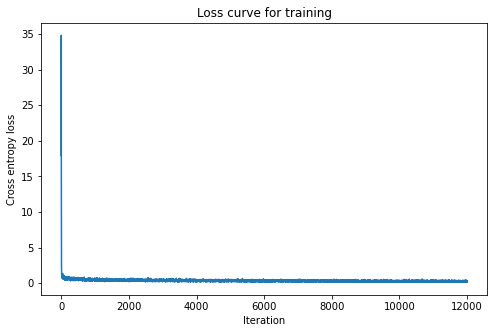

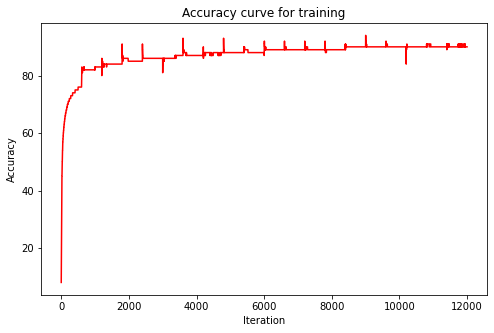

In [55]:
#Plots the loss and accuracy curves

plt.figure(figsize=(8,5))
plt.plot(range(len(train_loss)), train_loss)
plt.xlabel("Iteration")
plt.ylabel("Cross entropy loss")
plt.title("Loss curve for training")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(len(train_accuracy)), train_accuracy, c='r')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy curve for training")
plt.show()

In [56]:
save_model = True
if save_model is True:
    torch.save(model.state_dict(), path+"\\FNN_pytorch_6_layer_fashion-mnist.pkl")# only save parameters